<a href="https://colab.research.google.com/github/myredex/collecting_stock_data/blob/master/06_pytorch_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images classification using pytorch

## Imports

In [1]:
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from collections import Counter
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
!wget https://raw.githubusercontent.com/myredex/functions/master/pytorch_helpers_functions.py
import pytorch_helpers_functions
from torch.utils.data import random_split, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

--2024-08-13 07:23:40--  https://raw.githubusercontent.com/myredex/functions/master/pytorch_helpers_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556 (1.5K) [text/plain]
Saving to: ‘pytorch_helpers_functions.py’

pytorch_helpers_fun 100%[===================>]   1.52K  --.-KB/s    in 0.001s  

2024-08-13 07:23:40 (2.24 MB/s) - ‘pytorch_helpers_functions.py’ saved [1556/1556]



## Get data

In [2]:
# Download data
!gdown 1whwwZpgT13oLDDzoUNJbu-eI1jMCOAlg

Downloading...
From (original): https://drive.google.com/uc?id=1whwwZpgT13oLDDzoUNJbu-eI1jMCOAlg
From (redirected): https://drive.google.com/uc?id=1whwwZpgT13oLDDzoUNJbu-eI1jMCOAlg&confirm=t&uuid=2702530f-8f88-4a71-b6d2-8833e853ddb3
To: /content/images_fruits_classification_unballanced.zip
100% 127M/127M [00:05<00:00, 21.5MB/s]


In [3]:
# Unzip it
zipref = zipfile.ZipFile("/content/images_fruits_classification_unballanced.zip")
zipref.extractall()
zipref.close()

## Basic data exploration

In [4]:
dataset = datasets.ImageFolder("images")
class_counts = Counter(dataset.targets)
for class_idx, count in class_counts.items():
    print(f"There are '{dataset.classes[class_idx]}' class with {count} images")

There are 'apple fruit' class with 40 images
There are 'cherry fruit' class with 40 images
There are 'chickoo fruit' class with 40 images
There are 'grapes fruit' class with 20 images
There are 'kiwi fruit' class with 24 images
There are 'mango fruit' class with 10 images
There are 'orange fruit' class with 16 images


## Visualize some data

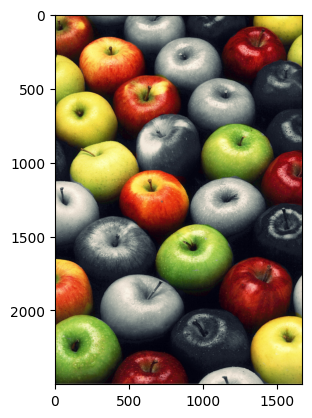

In [5]:
image = mpimg.imread(random.choice(dataset.samples)[0])
plt.imshow(image)
plt.show()

## Create dataset and transform images

In [6]:
# Calculate mean and std for the dataset
mean, std = pytorch_helpers_functions.calculate_mean_std('images')
print(f"Mean: {mean}")
print(f"Std: {std}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Mean: tensor([0.6839, 0.5927, 0.4622])
Std: tensor([0.2121, 0.2540, 0.2848])


In [24]:
img_size = (64, 64)
BATCH_SIZE = 8

# Set transformation parameters in dataset
transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])

# Create dataset instance
dataset = datasets.ImageFolder(root='images',
                               transform=transform)

# Count size of datasets
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size

# Split data into train, test, validation
train_dataset, test_dataset, val_dataset = random_split(dataset,
                                                        [train_size,
                                                         test_size,
                                                         val_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
val_dataloader = DataLoader(val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

## Create model

In [25]:
# Create model's class
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Replace final layer
        self.model.fc = nn.Linear(self.model.fc.in_features,
                                  num_classes)
    def forward(self, x):
        return self.model(x)

In [26]:
# Instanciate the model
num_classes = len(dataset.classes)
model = SimpleCNN(num_classes=num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),
                       lr=0.01)

## Train model

In [29]:
for images, labels in train_dataloader:

    print(images.size(0))

8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
5


In [31]:
model.train()
epochs = 3

for epoch in range(epochs):
    # Training loop
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        # Do the forward pass
        y_pred = model(X).float()

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        print(loss)

        # Optimizer zero grad
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}")


tensor(3.1950, grad_fn=<NllLossBackward0>)
tensor(2.2547, grad_fn=<NllLossBackward0>)
tensor(4.7024, grad_fn=<NllLossBackward0>)
tensor(3.8721, grad_fn=<NllLossBackward0>)
tensor(4.3670, grad_fn=<NllLossBackward0>)
tensor(3.3667, grad_fn=<NllLossBackward0>)
tensor(1.9430, grad_fn=<NllLossBackward0>)
tensor(5.0797, grad_fn=<NllLossBackward0>)
tensor(4.8518, grad_fn=<NllLossBackward0>)
tensor(7.8149, grad_fn=<NllLossBackward0>)
tensor(2.7322, grad_fn=<NllLossBackward0>)
tensor(5.4701, grad_fn=<NllLossBackward0>)
tensor(1.5626, grad_fn=<NllLossBackward0>)
tensor(3.9570, grad_fn=<NllLossBackward0>)
tensor(6.7281, grad_fn=<NllLossBackward0>)
tensor(1.9663, grad_fn=<NllLossBackward0>)
tensor(1.1766, grad_fn=<NllLossBackward0>)
Epoch 0
tensor(1.4714, grad_fn=<NllLossBackward0>)
tensor(6.0748, grad_fn=<NllLossBackward0>)
tensor(3.5244, grad_fn=<NllLossBackward0>)
tensor(2.4867, grad_fn=<NllLossBackward0>)
tensor(1.7896, grad_fn=<NllLossBackward0>)
tensor(6.0948, grad_fn=<NllLossBackward0>)
ten